## Detect energy-saving appliances at home
---

In [1]:
import os
import numpy as np
import xml.etree.ElementTree as ET
import torch
from PIL import Image
import matplotlib.pyplot as plt

import cv2

## Dataset pipeline
---
> **기능** : **IMAGE** 및 **XML**(Anotation : [label, bbox]) 파일을 읽어 COCO API의 INPUT 맞도록 함
>
> **참고 자료** : [TORCHVISION 객체 검출 미세조정(FINETUNING) 튜토리얼](https://tutorials.pytorch.kr/intermediate/torchvision_tutorial.html) 참고하여 본 프로젝트에 알맞도록 수정

In [2]:
class Dataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # 모든 이미지 파일들을 읽고, 정렬하여
        # 이미지와 Object Detection의 BBox 정렬을 확인합니다.
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):
        # 이미지와 박스를 읽어옵니다
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        boxes_path = os.path.join(self.root, "Annotations", self.boxes[idx])
        img = Image.open(img_path).convert("RGB")
        
        boxes = []
        labels = []
        label = None
        tree = ET.parse(boxes_path)
        root = tree.getroot()
        num_objs = len(root.findall('object'))
        for member in root.findall('object'):
            value = (
                member[0].text.lower(),
                int(member[4][0].text),
                int(member[4][1].text),
                int(member[4][2].text),
                int(member[4][3].text)
            )            
            # xml parsing을 위한 debug 용도
            # print(value[0])
            if value[0] == 'tv on':
                label = 0
            elif value[0] == 'tv off':
                label = 1
            elif value[0] == 'led lights on':
                label = 2
            elif value[0] == 'led lights off':
                label = 3
            elif value[0] == 'drum washing machine':
                label = 4
            elif value[0] == 'washing machine':
                label = 5                
            elif value[0] == 'monitor on':
                label = 6
            elif value[0] == 'monitor off':
                label = 7
            elif value[0] == 'pc':
                label = 8
            elif value[0] == 'dehumidifier':
                label = 9
            elif value[0] == 'air cleaner':
                label = 10
            elif value[0] == 'electric port':
                label = 11
            elif value[0] == 'refrigerator':
                label = 12
            elif value[0] == 'kimchi refrigerator':
                label = 13
            elif value[0] == 'electric rice cooker':
                label = 14               
            elif value[0] == 'microwave':
                label = 15
            elif value[0] == 'fan':
                label = 16
            elif value[0] == 'air conditioner':
                label = 17
            else:
                continue
            
            labels.append(label)
            boxes.append(value[1:])
        
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        #print(value[0])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area        
        target["iscrowd"] = iscrowd
        
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## use our dataset and defined transformations
---
> data set을 좌/우 대칭시켜 데이터 갯수 2배 늘어나도록 함

In [3]:
from detection.engine import train_one_epoch, evaluate
from detection import utils
from detection import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

In [4]:
# use our dataset and defined transformations
dataset = Dataset('data', get_transform(train=True))
dataset_test = Dataset('data', get_transform(train=False))

# split the dataset in train and test set (7:3)
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:int(len(indices)*0.7)])
dataset_test = torch.utils.data.Subset(dataset_test, indices[int(len(indices)*0.7):])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [14]:
for i, j in data_loader_test:
    print('img : ', np.shape(i[0]))
    print('-------------')
    print('target :',j)
    print('-----------------------------------------------------------------')

img :  torch.Size([3, 400, 600])
-------------
target : ({'boxes': tensor([[210.,  89., 509., 387.]]), 'labels': tensor([9]), 'image_id': tensor([1797]), 'area': tensor([89102.]), 'iscrowd': tensor([0])},)
-----------------------------------------------------------------
img :  torch.Size([3, 400, 533])
-------------
target : ({'boxes': tensor([[176., 133., 481., 437.]]), 'labels': tensor([16]), 'image_id': tensor([527]), 'area': tensor([92720.]), 'iscrowd': tensor([0])},)
-----------------------------------------------------------------
img :  torch.Size([3, 600, 1000])
-------------
target : ({'boxes': tensor([[581., 247., 724., 390.],
        [504., 169., 650., 315.]]), 'labels': tensor([3, 2]), 'image_id': tensor([1623]), 'area': tensor([20449., 21316.]), 'iscrowd': tensor([0, 0])},)
-----------------------------------------------------------------
img :  torch.Size([3, 600, 1000])
-------------
target : ({'boxes': tensor([[ 36., 196., 953., 378.]]), 'labels': tensor([2]), 'image_i

ParseError: not well-formed (invalid token): line 1, column 0 (<string>)

## fasterrcnn_resnet50_fpn (model) 불러와서 Fine-Tuning

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance(num_classes):
    # COCO 에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # 분류를 위한 입력 특징 차원을 얻습니다
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 미리 학습된 헤더를 새로운 것으로 바꿉니다
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### GPU Allocation 변경하기

In [6]:
# GPU 할당 변경하기
GPU_NUM = 6 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  6
GeForce GTX 1080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
# hyper parameter 설정
num_epochs = 5
lr = 0.005
batch_size = 2


# 데이터셋은 n 개의 클래스
num_classes = 18


# 데이터셋과 정의된 변환들을 사용합니다
dataset = Dataset('data', get_transform(train=True))
dataset_test = Dataset('data', get_transform(train=False))

# 데이터셋을 학습용과 테스트용으로 나눕니다 (7:3의 비율로 실행)
# torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:int(len(indices)*0.7)])
dataset_test = torch.utils.data.Subset(dataset_test, indices[int(len(indices)*0.7):])

# 데이터 로더를 학습용과 검증용으로 정의합니다
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


# 도움 함수를 이용해 모델을 가져옵니다
model = get_model_instance(num_classes)


# 모델을 GPU나 CPU로 옮깁니다
model.to(device)


# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,
                             momentum=0.9, weight_decay=0.0005)


# optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999), weight_decay=0.0005)


# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## 학습 시작

In [8]:
for epoch in range(num_epochs):
    # 1 에포크동안 학습하고, 10회 마다 출력합니다
    
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # 학습률을 업데이트 합니다
    lr_scheduler.step()
    # 테스트 데이터셋에서 평가를 합니다
    evaluate(model, data_loader_test, device=device)


# save
savePath = "output/Num_Epoch_"+str(num_epochs)+"_lr_"+str(lr)+"_MAP_300_test_model.pth"
torch.save(model.state_dict(), savePath)

Epoch: [0]  [   0/1150]  eta: 0:16:25  lr: 0.000010  loss: 3.4700 (3.4700)  loss_classifier: 3.3115 (3.3115)  loss_box_reg: 0.0571 (0.0571)  loss_objectness: 0.0820 (0.0820)  loss_rpn_box_reg: 0.0194 (0.0194)  time: 0.8573  data: 0.0483  max mem: 3432
Epoch: [0]  [  10/1150]  eta: 0:10:44  lr: 0.000060  loss: 3.2757 (3.2507)  loss_classifier: 3.1490 (3.0785)  loss_box_reg: 0.0955 (0.0898)  loss_objectness: 0.0470 (0.0648)  loss_rpn_box_reg: 0.0138 (0.0176)  time: 0.5656  data: 0.0306  max mem: 4030
Epoch: [0]  [  20/1150]  eta: 0:10:25  lr: 0.000110  loss: 2.9459 (2.5848)  loss_classifier: 2.6329 (2.3926)  loss_box_reg: 0.0772 (0.0817)  loss_objectness: 0.0470 (0.0791)  loss_rpn_box_reg: 0.0147 (0.0314)  time: 0.5385  data: 0.0271  max mem: 4030
Epoch: [0]  [  30/1150]  eta: 0:10:11  lr: 0.000160  loss: 0.8879 (1.9340)  loss_classifier: 0.6885 (1.7427)  loss_box_reg: 0.0619 (0.0827)  loss_objectness: 0.0491 (0.0743)  loss_rpn_box_reg: 0.0205 (0.0343)  time: 0.5357  data: 0.0236  max me

Epoch: [0]  [ 330/1150]  eta: 0:07:21  lr: 0.001658  loss: 0.2500 (0.6212)  loss_classifier: 0.1385 (0.3084)  loss_box_reg: 0.0694 (0.0703)  loss_objectness: 0.0147 (0.0858)  loss_rpn_box_reg: 0.0107 (0.1566)  time: 0.5413  data: 0.0288  max mem: 4030
Epoch: [0]  [ 340/1150]  eta: 0:07:16  lr: 0.001708  loss: 0.2202 (0.6111)  loss_classifier: 0.1283 (0.3041)  loss_box_reg: 0.0612 (0.0702)  loss_objectness: 0.0185 (0.0843)  loss_rpn_box_reg: 0.0107 (0.1525)  time: 0.5635  data: 0.0286  max mem: 4030
Epoch: [0]  [ 350/1150]  eta: 0:07:12  lr: 0.001758  loss: 0.2160 (0.5995)  loss_classifier: 0.1281 (0.2987)  loss_box_reg: 0.0595 (0.0697)  loss_objectness: 0.0180 (0.0825)  loss_rpn_box_reg: 0.0124 (0.1485)  time: 0.5736  data: 0.0207  max mem: 4030
Epoch: [0]  [ 360/1150]  eta: 0:07:06  lr: 0.001808  loss: 0.2196 (0.6707)  loss_classifier: 0.1327 (0.2952)  loss_box_reg: 0.0609 (0.0699)  loss_objectness: 0.0183 (0.0882)  loss_rpn_box_reg: 0.0151 (0.2174)  time: 0.5610  data: 0.0239  max me

Epoch: [0]  [ 660/1150]  eta: 0:04:26  lr: 0.003307  loss: 0.2180 (0.6226)  loss_classifier: 0.1093 (0.2330)  loss_box_reg: 0.0563 (0.0700)  loss_objectness: 0.0161 (0.0807)  loss_rpn_box_reg: 0.0131 (0.2389)  time: 0.5410  data: 0.0242  max mem: 4030
Epoch: [0]  [ 670/1150]  eta: 0:04:21  lr: 0.003357  loss: 0.2180 (0.6174)  loss_classifier: 0.1093 (0.2318)  loss_box_reg: 0.0595 (0.0698)  loss_objectness: 0.0157 (0.0800)  loss_rpn_box_reg: 0.0171 (0.2358)  time: 0.5239  data: 0.0247  max mem: 4030
Epoch: [0]  [ 680/1150]  eta: 0:04:15  lr: 0.003407  loss: 0.2375 (0.6122)  loss_classifier: 0.1334 (0.2306)  loss_box_reg: 0.0630 (0.0698)  loss_objectness: 0.0116 (0.0791)  loss_rpn_box_reg: 0.0208 (0.2326)  time: 0.5149  data: 0.0250  max mem: 4030
Epoch: [0]  [ 690/1150]  eta: 0:04:10  lr: 0.003457  loss: 0.2164 (0.6074)  loss_classifier: 0.1097 (0.2290)  loss_box_reg: 0.0521 (0.0695)  loss_objectness: 0.0192 (0.0784)  loss_rpn_box_reg: 0.0175 (0.2305)  time: 0.5589  data: 0.0233  max me

Epoch: [0]  [ 990/1150]  eta: 0:01:27  lr: 0.004955  loss: 0.2640 (0.5834)  loss_classifier: 0.1729 (0.2091)  loss_box_reg: 0.0653 (0.0685)  loss_objectness: 0.0161 (0.0696)  loss_rpn_box_reg: 0.0174 (0.2362)  time: 0.5541  data: 0.0220  max mem: 4030
Epoch: [0]  [1000/1150]  eta: 0:01:21  lr: 0.005000  loss: 0.2698 (0.5808)  loss_classifier: 0.1570 (0.2089)  loss_box_reg: 0.0653 (0.0686)  loss_objectness: 0.0181 (0.0692)  loss_rpn_box_reg: 0.0111 (0.2341)  time: 0.5555  data: 0.0245  max mem: 4030
Epoch: [0]  [1010/1150]  eta: 0:01:16  lr: 0.005000  loss: 0.2652 (0.5773)  loss_classifier: 0.1401 (0.2082)  loss_box_reg: 0.0634 (0.0685)  loss_objectness: 0.0160 (0.0687)  loss_rpn_box_reg: 0.0155 (0.2320)  time: 0.5429  data: 0.0247  max mem: 4030
Epoch: [0]  [1020/1150]  eta: 0:01:10  lr: 0.005000  loss: 0.1959 (0.5742)  loss_classifier: 0.1183 (0.2077)  loss_box_reg: 0.0359 (0.0684)  loss_objectness: 0.0160 (0.0683)  loss_rpn_box_reg: 0.0168 (0.2299)  time: 0.5338  data: 0.0269  max me

Epoch: [1]  [  50/1150]  eta: 0:09:53  lr: 0.005000  loss: 0.2443 (0.3579)  loss_classifier: 0.1211 (0.1312)  loss_box_reg: 0.0399 (0.0469)  loss_objectness: 0.0231 (0.0752)  loss_rpn_box_reg: 0.0175 (0.1046)  time: 0.5178  data: 0.0270  max mem: 4030
Epoch: [1]  [  60/1150]  eta: 0:09:47  lr: 0.005000  loss: 0.1998 (0.3341)  loss_classifier: 0.1133 (0.1295)  loss_box_reg: 0.0366 (0.0463)  loss_objectness: 0.0238 (0.0668)  loss_rpn_box_reg: 0.0175 (0.0915)  time: 0.5262  data: 0.0281  max mem: 4030
Epoch: [1]  [  70/1150]  eta: 0:09:40  lr: 0.005000  loss: 0.1722 (0.3150)  loss_classifier: 0.1039 (0.1285)  loss_box_reg: 0.0355 (0.0458)  loss_objectness: 0.0202 (0.0602)  loss_rpn_box_reg: 0.0119 (0.0804)  time: 0.5323  data: 0.0255  max mem: 4030
Epoch: [1]  [  80/1150]  eta: 0:09:31  lr: 0.005000  loss: 0.1580 (0.2979)  loss_classifier: 0.0790 (0.1250)  loss_box_reg: 0.0345 (0.0449)  loss_objectness: 0.0189 (0.0550)  loss_rpn_box_reg: 0.0119 (0.0730)  time: 0.5182  data: 0.0234  max me

Epoch: [1]  [ 380/1150]  eta: 0:06:47  lr: 0.005000  loss: 0.2078 (0.4107)  loss_classifier: 0.0858 (0.1328)  loss_box_reg: 0.0310 (0.0485)  loss_objectness: 0.0178 (0.0528)  loss_rpn_box_reg: 0.0215 (0.1767)  time: 0.5354  data: 0.0253  max mem: 4399
Epoch: [1]  [ 390/1150]  eta: 0:06:41  lr: 0.005000  loss: 0.1597 (0.4431)  loss_classifier: 0.0866 (0.1315)  loss_box_reg: 0.0335 (0.0480)  loss_objectness: 0.0197 (0.0579)  loss_rpn_box_reg: 0.0140 (0.2056)  time: 0.5185  data: 0.0270  max mem: 4399
Epoch: [1]  [ 400/1150]  eta: 0:06:36  lr: 0.005000  loss: 0.1618 (0.4366)  loss_classifier: 0.0901 (0.1308)  loss_box_reg: 0.0336 (0.0478)  loss_objectness: 0.0193 (0.0569)  loss_rpn_box_reg: 0.0139 (0.2011)  time: 0.5335  data: 0.0268  max mem: 4399
Epoch: [1]  [ 410/1150]  eta: 0:06:32  lr: 0.005000  loss: 0.1702 (0.4319)  loss_classifier: 0.0971 (0.1313)  loss_box_reg: 0.0352 (0.0479)  loss_objectness: 0.0171 (0.0561)  loss_rpn_box_reg: 0.0167 (0.1966)  time: 0.5528  data: 0.0285  max me

Epoch: [1]  [ 710/1150]  eta: 0:03:53  lr: 0.005000  loss: 0.2310 (0.7105)  loss_classifier: 0.1163 (0.1363)  loss_box_reg: 0.0421 (0.0492)  loss_objectness: 0.0228 (0.0978)  loss_rpn_box_reg: 0.0287 (0.4272)  time: 0.5069  data: 0.0227  max mem: 4399
Epoch: [1]  [ 720/1150]  eta: 0:03:48  lr: 0.005000  loss: 0.2180 (0.7059)  loss_classifier: 0.1214 (0.1370)  loss_box_reg: 0.0422 (0.0495)  loss_objectness: 0.0215 (0.0972)  loss_rpn_box_reg: 0.0203 (0.4222)  time: 0.5148  data: 0.0241  max mem: 4399
Epoch: [1]  [ 730/1150]  eta: 0:03:42  lr: 0.005000  loss: 0.2124 (0.7006)  loss_classifier: 0.1084 (0.1368)  loss_box_reg: 0.0389 (0.0494)  loss_objectness: 0.0252 (0.0964)  loss_rpn_box_reg: 0.0152 (0.4180)  time: 0.5280  data: 0.0269  max mem: 4399
Epoch: [1]  [ 740/1150]  eta: 0:03:37  lr: 0.005000  loss: 0.2124 (0.6942)  loss_classifier: 0.1016 (0.1366)  loss_box_reg: 0.0388 (0.0494)  loss_objectness: 0.0250 (0.0955)  loss_rpn_box_reg: 0.0140 (0.4126)  time: 0.5127  data: 0.0235  max me

Epoch: [1]  [1040/1150]  eta: 0:00:58  lr: 0.005000  loss: 0.1747 (0.6206)  loss_classifier: 0.0899 (0.1323)  loss_box_reg: 0.0301 (0.0476)  loss_objectness: 0.0200 (0.0862)  loss_rpn_box_reg: 0.0146 (0.3545)  time: 0.5556  data: 0.0232  max mem: 4399
Epoch: [1]  [1050/1150]  eta: 0:00:53  lr: 0.005000  loss: 0.1698 (0.6165)  loss_classifier: 0.1015 (0.1320)  loss_box_reg: 0.0323 (0.0475)  loss_objectness: 0.0199 (0.0857)  loss_rpn_box_reg: 0.0112 (0.3513)  time: 0.5399  data: 0.0233  max mem: 4399
Epoch: [1]  [1060/1150]  eta: 0:00:47  lr: 0.005000  loss: 0.1679 (0.6124)  loss_classifier: 0.1008 (0.1318)  loss_box_reg: 0.0336 (0.0474)  loss_objectness: 0.0156 (0.0850)  loss_rpn_box_reg: 0.0102 (0.3482)  time: 0.5471  data: 0.0292  max mem: 4399
Epoch: [1]  [1070/1150]  eta: 0:00:42  lr: 0.005000  loss: 0.1678 (0.6086)  loss_classifier: 0.0899 (0.1314)  loss_box_reg: 0.0331 (0.0473)  loss_objectness: 0.0156 (0.0846)  loss_rpn_box_reg: 0.0113 (0.3453)  time: 0.5247  data: 0.0291  max me

Epoch: [2]  [ 100/1150]  eta: 0:09:21  lr: 0.005000  loss: 0.2029 (0.4541)  loss_classifier: 0.1106 (0.1316)  loss_box_reg: 0.0450 (0.0459)  loss_objectness: 0.0215 (0.0749)  loss_rpn_box_reg: 0.0097 (0.2018)  time: 0.5474  data: 0.0267  max mem: 4399
Epoch: [2]  [ 110/1150]  eta: 0:09:16  lr: 0.005000  loss: 0.2201 (0.4393)  loss_classifier: 0.1129 (0.1354)  loss_box_reg: 0.0458 (0.0480)  loss_objectness: 0.0238 (0.0705)  loss_rpn_box_reg: 0.0186 (0.1854)  time: 0.5426  data: 0.0219  max mem: 4399
Epoch: [2]  [ 120/1150]  eta: 0:09:12  lr: 0.005000  loss: 0.2774 (0.4289)  loss_classifier: 0.1291 (0.1381)  loss_box_reg: 0.0509 (0.0498)  loss_objectness: 0.0189 (0.0668)  loss_rpn_box_reg: 0.0195 (0.1742)  time: 0.5450  data: 0.0211  max mem: 4399
Epoch: [2]  [ 130/1150]  eta: 0:09:06  lr: 0.005000  loss: 0.2597 (0.4138)  loss_classifier: 0.1399 (0.1374)  loss_box_reg: 0.0506 (0.0495)  loss_objectness: 0.0189 (0.0635)  loss_rpn_box_reg: 0.0195 (0.1633)  time: 0.5407  data: 0.0258  max me

Epoch: [2]  [ 430/1150]  eta: 0:06:25  lr: 0.005000  loss: 0.2584 (0.4223)  loss_classifier: 0.1105 (0.1337)  loss_box_reg: 0.0441 (0.0479)  loss_objectness: 0.0506 (0.0650)  loss_rpn_box_reg: 0.0143 (0.1757)  time: 0.5069  data: 0.0232  max mem: 4399
Epoch: [2]  [ 440/1150]  eta: 0:06:20  lr: 0.005000  loss: 0.2089 (0.4169)  loss_classifier: 0.1008 (0.1330)  loss_box_reg: 0.0418 (0.0478)  loss_objectness: 0.0418 (0.0641)  loss_rpn_box_reg: 0.0142 (0.1720)  time: 0.5258  data: 0.0294  max mem: 4399
Epoch: [2]  [ 450/1150]  eta: 0:06:15  lr: 0.005000  loss: 0.1596 (0.4123)  loss_classifier: 0.0931 (0.1327)  loss_box_reg: 0.0323 (0.0476)  loss_objectness: 0.0215 (0.0634)  loss_rpn_box_reg: 0.0124 (0.1686)  time: 0.5388  data: 0.0296  max mem: 4399
Epoch: [2]  [ 460/1150]  eta: 0:06:10  lr: 0.005000  loss: 0.1700 (0.4075)  loss_classifier: 0.0844 (0.1320)  loss_box_reg: 0.0208 (0.0473)  loss_objectness: 0.0211 (0.0627)  loss_rpn_box_reg: 0.0159 (0.1655)  time: 0.5477  data: 0.0262  max me

Epoch: [2]  [ 760/1150]  eta: 0:03:27  lr: 0.005000  loss: 0.1957 (0.4806)  loss_classifier: 0.1013 (0.1362)  loss_box_reg: 0.0349 (0.0478)  loss_objectness: 0.0227 (0.0619)  loss_rpn_box_reg: 0.0167 (0.2347)  time: 0.5172  data: 0.0261  max mem: 4399
Epoch: [2]  [ 770/1150]  eta: 0:03:22  lr: 0.005000  loss: 0.1691 (0.4770)  loss_classifier: 0.0841 (0.1356)  loss_box_reg: 0.0289 (0.0476)  loss_objectness: 0.0253 (0.0615)  loss_rpn_box_reg: 0.0195 (0.2323)  time: 0.5329  data: 0.0268  max mem: 4399
Epoch: [2]  [ 780/1150]  eta: 0:03:17  lr: 0.005000  loss: 0.1691 (0.4740)  loss_classifier: 0.0848 (0.1358)  loss_box_reg: 0.0309 (0.0476)  loss_objectness: 0.0233 (0.0610)  loss_rpn_box_reg: 0.0105 (0.2295)  time: 0.5294  data: 0.0270  max mem: 4399
Epoch: [2]  [ 790/1150]  eta: 0:03:11  lr: 0.005000  loss: 0.1692 (0.4703)  loss_classifier: 0.0965 (0.1355)  loss_box_reg: 0.0361 (0.0475)  loss_objectness: 0.0172 (0.0605)  loss_rpn_box_reg: 0.0107 (0.2268)  time: 0.5139  data: 0.0245  max me

Epoch: [2]  [1090/1150]  eta: 0:00:32  lr: 0.005000  loss: 0.2066 (0.5574)  loss_classifier: 0.1363 (0.1314)  loss_box_reg: 0.0486 (0.0464)  loss_objectness: 0.0190 (0.0726)  loss_rpn_box_reg: 0.0114 (0.3070)  time: 0.5478  data: 0.0221  max mem: 4399
Epoch: [2]  [1100/1150]  eta: 0:00:26  lr: 0.005000  loss: 0.2008 (0.5550)  loss_classifier: 0.1342 (0.1318)  loss_box_reg: 0.0489 (0.0466)  loss_objectness: 0.0179 (0.0722)  loss_rpn_box_reg: 0.0119 (0.3045)  time: 0.5140  data: 0.0217  max mem: 4399
Epoch: [2]  [1110/1150]  eta: 0:00:21  lr: 0.005000  loss: 0.1986 (0.5518)  loss_classifier: 0.1204 (0.1316)  loss_box_reg: 0.0489 (0.0466)  loss_objectness: 0.0187 (0.0717)  loss_rpn_box_reg: 0.0115 (0.3018)  time: 0.5228  data: 0.0228  max mem: 4399
Epoch: [2]  [1120/1150]  eta: 0:00:16  lr: 0.005000  loss: 0.1885 (0.5489)  loss_classifier: 0.1045 (0.1317)  loss_box_reg: 0.0375 (0.0466)  loss_objectness: 0.0179 (0.0713)  loss_rpn_box_reg: 0.0115 (0.2994)  time: 0.5266  data: 0.0242  max me

Epoch: [3]  [ 150/1150]  eta: 0:08:45  lr: 0.000500  loss: 0.1721 (0.5371)  loss_classifier: 0.0883 (0.1223)  loss_box_reg: 0.0228 (0.0447)  loss_objectness: 0.0151 (0.0633)  loss_rpn_box_reg: 0.0114 (0.3069)  time: 0.5327  data: 0.0242  max mem: 4399
Epoch: [3]  [ 160/1150]  eta: 0:08:44  lr: 0.000500  loss: 0.1787 (0.5181)  loss_classifier: 0.0907 (0.1221)  loss_box_reg: 0.0358 (0.0448)  loss_objectness: 0.0141 (0.0610)  loss_rpn_box_reg: 0.0132 (0.2903)  time: 0.5711  data: 0.0248  max mem: 4399
Epoch: [3]  [ 170/1150]  eta: 0:08:41  lr: 0.000500  loss: 0.1706 (0.4968)  loss_classifier: 0.1032 (0.1205)  loss_box_reg: 0.0370 (0.0440)  loss_objectness: 0.0140 (0.0584)  loss_rpn_box_reg: 0.0137 (0.2740)  time: 0.5833  data: 0.0237  max mem: 4399
Epoch: [3]  [ 180/1150]  eta: 0:08:34  lr: 0.000500  loss: 0.1543 (0.4837)  loss_classifier: 0.1002 (0.1217)  loss_box_reg: 0.0339 (0.0447)  loss_objectness: 0.0160 (0.0565)  loss_rpn_box_reg: 0.0126 (0.2608)  time: 0.5372  data: 0.0242  max me

Epoch: [3]  [ 480/1150]  eta: 0:05:52  lr: 0.000500  loss: 0.1979 (0.3864)  loss_classifier: 0.0834 (0.1204)  loss_box_reg: 0.0358 (0.0446)  loss_objectness: 0.0162 (0.0496)  loss_rpn_box_reg: 0.0151 (0.1717)  time: 0.5373  data: 0.0248  max mem: 4399
Epoch: [3]  [ 490/1150]  eta: 0:05:46  lr: 0.000500  loss: 0.1855 (0.3967)  loss_classifier: 0.1014 (0.1202)  loss_box_reg: 0.0292 (0.0445)  loss_objectness: 0.0137 (0.0533)  loss_rpn_box_reg: 0.0134 (0.1787)  time: 0.5220  data: 0.0248  max mem: 4399
Epoch: [3]  [ 500/1150]  eta: 0:05:41  lr: 0.000500  loss: 0.1812 (0.4278)  loss_classifier: 0.1028 (0.1205)  loss_box_reg: 0.0292 (0.0447)  loss_objectness: 0.0162 (0.0565)  loss_rpn_box_reg: 0.0191 (0.2061)  time: 0.5138  data: 0.0246  max mem: 4399
Epoch: [3]  [ 510/1150]  eta: 0:05:36  lr: 0.000500  loss: 0.1668 (0.4230)  loss_classifier: 0.0896 (0.1199)  loss_box_reg: 0.0322 (0.0445)  loss_objectness: 0.0192 (0.0558)  loss_rpn_box_reg: 0.0169 (0.2028)  time: 0.5226  data: 0.0234  max me

Epoch: [3]  [ 810/1150]  eta: 0:03:00  lr: 0.000500  loss: 0.2147 (0.5066)  loss_classifier: 0.0906 (0.1175)  loss_box_reg: 0.0409 (0.0440)  loss_objectness: 0.0228 (0.0620)  loss_rpn_box_reg: 0.0167 (0.2831)  time: 0.5410  data: 0.0284  max mem: 4399
Epoch: [3]  [ 820/1150]  eta: 0:02:55  lr: 0.000500  loss: 0.2147 (0.5032)  loss_classifier: 0.1210 (0.1176)  loss_box_reg: 0.0452 (0.0441)  loss_objectness: 0.0232 (0.0616)  loss_rpn_box_reg: 0.0235 (0.2800)  time: 0.5175  data: 0.0271  max mem: 4399
Epoch: [3]  [ 830/1150]  eta: 0:02:49  lr: 0.000500  loss: 0.2051 (0.5010)  loss_classifier: 0.1268 (0.1180)  loss_box_reg: 0.0537 (0.0443)  loss_objectness: 0.0181 (0.0612)  loss_rpn_box_reg: 0.0170 (0.2776)  time: 0.5378  data: 0.0236  max mem: 4399
Epoch: [3]  [ 840/1150]  eta: 0:02:44  lr: 0.000500  loss: 0.2152 (0.4980)  loss_classifier: 0.1295 (0.1181)  loss_box_reg: 0.0543 (0.0444)  loss_objectness: 0.0181 (0.0607)  loss_rpn_box_reg: 0.0152 (0.2748)  time: 0.5436  data: 0.0248  max me

Epoch: [3]  [1140/1150]  eta: 0:00:05  lr: 0.000500  loss: 0.1385 (0.4658)  loss_classifier: 0.0889 (0.1177)  loss_box_reg: 0.0295 (0.0441)  loss_objectness: 0.0165 (0.0551)  loss_rpn_box_reg: 0.0100 (0.2490)  time: 0.5398  data: 0.0251  max mem: 4399
Epoch: [3]  [1149/1150]  eta: 0:00:00  lr: 0.000500  loss: 0.1470 (0.4713)  loss_classifier: 0.0908 (0.1177)  loss_box_reg: 0.0237 (0.0441)  loss_objectness: 0.0160 (0.0565)  loss_rpn_box_reg: 0.0112 (0.2530)  time: 0.5216  data: 0.0210  max mem: 4399
Epoch: [3] Total time: 0:10:10 (0.5305 s / it)
creating index...
index created!
Test:  [  0/986]  eta: 0:02:11  model_time: 0.1054 (0.1054)  evaluator_time: 0.0037 (0.0037)  time: 0.1332  data: 0.0106  max mem: 4399
Test:  [100/986]  eta: 0:01:32  model_time: 0.0933 (0.0931)  evaluator_time: 0.0025 (0.0026)  time: 0.1057  data: 0.0077  max mem: 4399
Test:  [200/986]  eta: 0:01:22  model_time: 0.0909 (0.0934)  evaluator_time: 0.0025 (0.0026)  time: 0.1054  data: 0.0100  max mem: 4399
Test:  [

Epoch: [4]  [ 200/1150]  eta: 0:08:17  lr: 0.000500  loss: 0.2091 (0.5252)  loss_classifier: 0.0875 (0.1154)  loss_box_reg: 0.0431 (0.0438)  loss_objectness: 0.0266 (0.0653)  loss_rpn_box_reg: 0.0162 (0.3007)  time: 0.5116  data: 0.0281  max mem: 4399
Epoch: [4]  [ 210/1150]  eta: 0:08:12  lr: 0.000500  loss: 0.1988 (0.5118)  loss_classifier: 0.1137 (0.1159)  loss_box_reg: 0.0435 (0.0445)  loss_objectness: 0.0262 (0.0637)  loss_rpn_box_reg: 0.0162 (0.2877)  time: 0.5237  data: 0.0288  max mem: 4399
Epoch: [4]  [ 220/1150]  eta: 0:08:10  lr: 0.000500  loss: 0.2161 (0.5447)  loss_classifier: 0.0973 (0.1158)  loss_box_reg: 0.0308 (0.0443)  loss_objectness: 0.0248 (0.0705)  loss_rpn_box_reg: 0.0167 (0.3141)  time: 0.5602  data: 0.0407  max mem: 4399
Epoch: [4]  [ 230/1150]  eta: 0:08:03  lr: 0.000500  loss: 0.1791 (0.5305)  loss_classifier: 0.0820 (0.1162)  loss_box_reg: 0.0244 (0.0443)  loss_objectness: 0.0246 (0.0686)  loss_rpn_box_reg: 0.0129 (0.3013)  time: 0.5413  data: 0.0394  max me

Epoch: [4]  [ 530/1150]  eta: 0:05:27  lr: 0.000500  loss: 0.1517 (0.4550)  loss_classifier: 0.0914 (0.1134)  loss_box_reg: 0.0382 (0.0430)  loss_objectness: 0.0186 (0.0544)  loss_rpn_box_reg: 0.0078 (0.2443)  time: 0.5371  data: 0.0292  max mem: 4399
Epoch: [4]  [ 540/1150]  eta: 0:05:22  lr: 0.000500  loss: 0.1739 (0.4495)  loss_classifier: 0.0914 (0.1129)  loss_box_reg: 0.0287 (0.0428)  loss_objectness: 0.0139 (0.0537)  loss_rpn_box_reg: 0.0080 (0.2402)  time: 0.5247  data: 0.0270  max mem: 4399
Epoch: [4]  [ 550/1150]  eta: 0:05:17  lr: 0.000500  loss: 0.1723 (0.4881)  loss_classifier: 0.0768 (0.1123)  loss_box_reg: 0.0196 (0.0425)  loss_objectness: 0.0147 (0.0567)  loss_rpn_box_reg: 0.0097 (0.2766)  time: 0.5255  data: 0.0229  max mem: 4399
Epoch: [4]  [ 560/1150]  eta: 0:05:12  lr: 0.000500  loss: 0.1405 (0.4820)  loss_classifier: 0.0710 (0.1119)  loss_box_reg: 0.0210 (0.0423)  loss_objectness: 0.0151 (0.0560)  loss_rpn_box_reg: 0.0097 (0.2719)  time: 0.5529  data: 0.0234  max me

Epoch: [4]  [ 860/1150]  eta: 0:02:33  lr: 0.000500  loss: 0.1763 (0.4862)  loss_classifier: 0.0839 (0.1109)  loss_box_reg: 0.0305 (0.0419)  loss_objectness: 0.0206 (0.0565)  loss_rpn_box_reg: 0.0174 (0.2768)  time: 0.5700  data: 0.0220  max mem: 4399
Epoch: [4]  [ 870/1150]  eta: 0:02:28  lr: 0.000500  loss: 0.1586 (0.4824)  loss_classifier: 0.0839 (0.1106)  loss_box_reg: 0.0320 (0.0418)  loss_objectness: 0.0237 (0.0561)  loss_rpn_box_reg: 0.0143 (0.2739)  time: 0.5363  data: 0.0230  max mem: 4399
Epoch: [4]  [ 880/1150]  eta: 0:02:22  lr: 0.000500  loss: 0.1503 (0.4796)  loss_classifier: 0.0885 (0.1108)  loss_box_reg: 0.0321 (0.0419)  loss_objectness: 0.0237 (0.0559)  loss_rpn_box_reg: 0.0113 (0.2710)  time: 0.5187  data: 0.0240  max mem: 4399
Epoch: [4]  [ 890/1150]  eta: 0:02:17  lr: 0.000500  loss: 0.1862 (0.4765)  loss_classifier: 0.0885 (0.1106)  loss_box_reg: 0.0282 (0.0419)  loss_objectness: 0.0229 (0.0556)  loss_rpn_box_reg: 0.0178 (0.2684)  time: 0.5201  data: 0.0221  max me

Test:  [500/986]  eta: 0:00:51  model_time: 0.0932 (0.0933)  evaluator_time: 0.0025 (0.0028)  time: 0.1060  data: 0.0085  max mem: 4399
Test:  [600/986]  eta: 0:00:40  model_time: 0.0914 (0.0934)  evaluator_time: 0.0028 (0.0028)  time: 0.1034  data: 0.0082  max mem: 4399
Test:  [700/986]  eta: 0:00:30  model_time: 0.0925 (0.0934)  evaluator_time: 0.0027 (0.0028)  time: 0.1042  data: 0.0074  max mem: 4399
Test:  [800/986]  eta: 0:00:19  model_time: 0.0948 (0.0935)  evaluator_time: 0.0024 (0.0028)  time: 0.1134  data: 0.0151  max mem: 4399
Test:  [900/986]  eta: 0:00:09  model_time: 0.0932 (0.0933)  evaluator_time: 0.0028 (0.0028)  time: 0.1058  data: 0.0094  max mem: 4399
Test:  [985/986]  eta: 0:00:00  model_time: 0.0909 (0.0933)  evaluator_time: 0.0027 (0.0028)  time: 0.1021  data: 0.0072  max mem: 4399
Test: Total time: 0:01:43 (0.1054 s / it)
Averaged stats: model_time: 0.0909 (0.0933)  evaluator_time: 0.0027 (0.0028)
Accumulating evaluation results...
DONE (t=0.59s).
IoU metric: bb

In [24]:
# # GPU 할당 변경하기
# GPU_NUM = 6 # 원하는 GPU 번호 입력
# device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_device(device) # change allocation of current GPU
# print ('Current cuda device ', torch.cuda.current_device()) # check

# # Additional Infos
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(GPU_NUM))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  6
GeForce GTX 1080
Memory Usage:
Allocated: 0.3 GB
Cached:    0.5 GB


In [11]:
# device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
# model = get_model_instance(num_classes)
# model.load_state_dict(torch.load(savePath, map_location="cuda:"+str(device.index)))  # 사용할 GPU 장치 번호를 선택합니다.
# model.to(device)

## Test

In [9]:
import pandas as pd

APPLIANCES_INSTANCE_CATEGORY_NAMES = list(pd.read_excel('Detect energy-saving appliances at home.xlsx')['name'].values)

In [10]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    img = transform(img) # Apply the transform to the image
    
    with torch.no_grad():
        pred = model([img.to(device)]) # Pass the image to the model
        pred_class = [APPLIANCES_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())] # Get the Prediction Score
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())] # Bounding boxes
        pred_score = list(pred[0]['scores'].detach().cpu().numpy())
        pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
        pred_t = [pred_score.index(x) for x in pred_score][-1] 
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
        
    return pred_boxes, pred_class

In [11]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):

    boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB\
    #print(len(pred_cls))
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
    plt.figure(figsize=(10,10)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### 학습된 모델을 활용하여 test data 적용

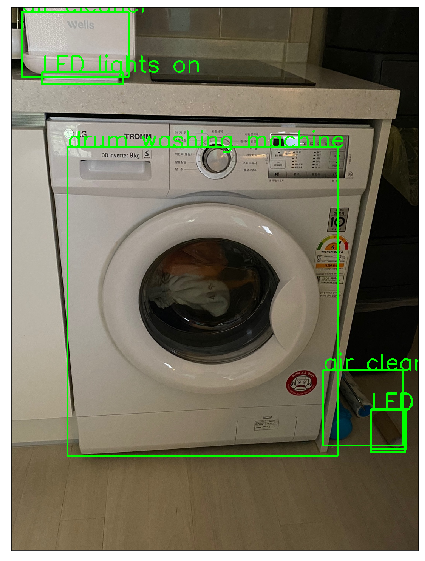

In [13]:
object_detection_api('/home/haejoong/Git/cs231_2017_final/pytorch/data/TestImages/12.jpg', threshold=0.57, text_size=2)

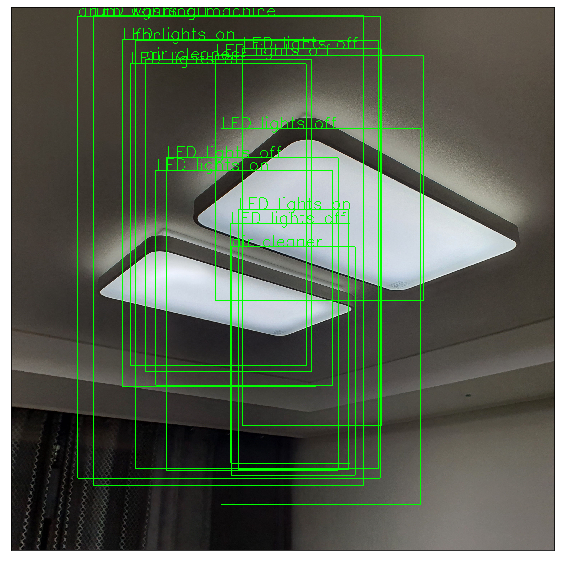

In [36]:
object_detection_api('/home/haejoong/Git/cs231_2017_final/pytorch/data/TestImages/43.jpg', threshold=0.5)

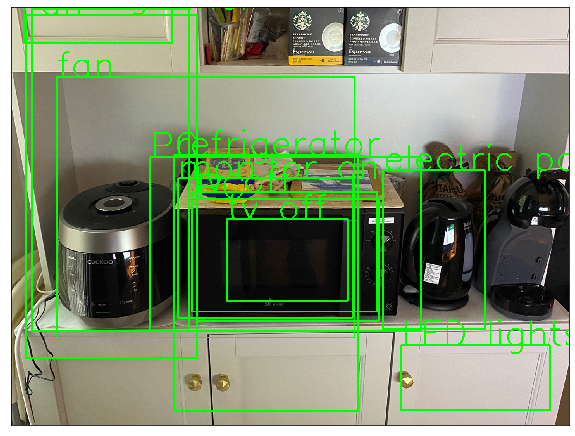

In [45]:
object_detection_api('/home/haejoong/Git/cs231_2017_final/pytorch/data/TestImages/9.jpg', threshold=0.3)

https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/

## Pretrained Model

#### Define the class names given by PyTorch’s official Docs

## Prediction of the model

In [371]:
import torchvision
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [372]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    img = transform(img) # Apply the transform to the image
    #device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    with torch.no_grad():
        pred = model([img])
        pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
        pred_score = list(pred[0]['scores'].detach().numpy())
        pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

In [373]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):

    boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
    plt.figure(figsize=(10,10)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

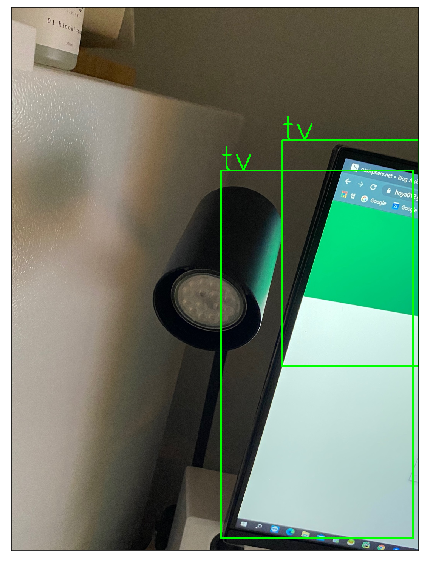

In [378]:
object_detection_api('/home/haejoong/Git/cs231_2017_final/pytorch/data/JPEGImages/2.jpg', threshold=0.5)